# Analysis using 3 nearest neighbors on crime: Alcohol, Drugs and fight
## 1. Basic idea
The idea is simple: crimes are not uniformly destributed. It can be reflected by the businesses around it and be affected by the type of business. A fight happens more often in bars than in offices, a gun is more likely to be found by a shooting range, a car stealing is more likely to be reflected by wealth of surroundings.  
In this part I want to investigate **alcohol, drugs and fights** and its connection to **3 nearset shops**. 
## 2. My approach outline
`def closest_3_business(lon, lat)` is a function that takes a point as an input, output 3 cloest shops types, as well as its distance.  
  
1. **filter out** alcohol crime stops from `reasonable_df`
2. find 3 **cloest shops** for all the data
3. **sum up** the count for every kind of shops
4. **eliminate the offset**: divide all the counts by the number of shops in San Diego
5. **compare the final value** that reflect the correation between business types and alcochol crimes
6. execute same process on **Drug data** and **fight**

### 2.1 Why I do offset on step3?
There are 2657 construction sites in San Deigo, while there are only 6 data processing center. There is no double that construction site appears more often near the crime only because they have more pin on the map.  
This is what I want to offset. It is the type of busines that affect the crime, not the number of sites.

### 2.2 How did I implemented `def closest_3_business(lon, lat)`
It is very time consuming to get distance based on latitude and longitude because this is not Euclidean distance and both lat & lon are not strait line.  
Based on this, I used a threshold to judge wether this point is likely to be closest point or not. This simple method works really well, ruling about 99% points out and, with the help of tuple calculaiton, pushing the speed of one iteration from **7 second** to **20 ms**

In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import sklearn


In [2]:
traffic_df = pd.read_csv("traffic_crime.csv")
traffic_df = traffic_df.set_index("stop_id")
business_df = pd.read_csv("business_clean_df.csv")
reasonable_df = pd.read_csv("reasonable_crime.csv")
reasonable_df = reasonable_df.set_index("stop_id")
business_df = business_df[["ACTIVITY DESC", "lon", "lat"]]

In [3]:
# business_reasonable_df = business_df

In [4]:
def getDistanceTo(lon1, lat1, lon2, lat2) :
    coords_1 = (lat1, lon1)
    coords_2 = (lat2, lon2)
    return geopy.distance.vincenty(coords_1, coords_2).miles

In [5]:
def substitute(li, newPair):
    for i in range(3):
        if li[i][1] > newPair[1]:
            li[i] = newPair
            break
    return li

import math
def closest_3_business(lon, lat, threshold=0.003):
    li = [('-', 10000000), ('-', 10000000), ('-', 10000000)]
    hit = 0
    for row in business_df.itertuples():
        lon2 = row[2]
        lat2 = row[3]
        if abs(lon - lon2) > threshold or abs(lat - lat2) > threshold:
            continue
        else:
            distance = getDistanceTo(lon1=lon, lat1=lat, lon2=lon2, lat2=lat2)
            hit += 1
            # biggest index
            biggest_index = 0
            for i in range(3):
                if li[i][1] > li[biggest_index][1]:
                    biggest_index = i

            # modify the list
            if distance < li[biggest_index][1]:
                li[biggest_index] = (row[1], distance)
    
    if ('-', 10000000) in  li:
        return closest_3_business(lon, lat, threshold+0.1)
                
#     print(hit)
    return li

def insert_adapter(business1, business2, business3, distance1, distance2, distance3, target):
    # ready to insert into dataframe
    business1.append(target[0][0])
    business2.append(target[1][0])
    business3.append(target[2][0])
    distance1.append(target[0][1])
    distance2.append(target[1][1])
    distance3.append(target[2][1])

In [6]:
# test unit. if you have problem executing func: closest_3_businesses(), check whether this block works well.

# lon = reasonable_df.iat[(0,1)] #-117.07028000000001
# lat = reasonable_df.iat[(0,2)] #32.75826
# print(closest_3_business(lon=lon, lat=lat))
# print(type(lon))
# print(type(lat))
# business_df.iat([0,1])
# n = 10
# for row in business_df.iterrows():
# #     print(row["lon"])
#     print(row[1  ]["lon"])
#     n -= 1
#     if n <-0:
#         break

In [7]:
reasonable_df.describe()

,crime_type,lon,lat
count,32375,32375,32375
unique,18,6037,6257
top,*local ordinance violation*,-117.15366,32.706276
freq,4891,658,774


In [8]:
reasonable_df['crime_type'].value_counts()

*local ordinance violation*     4891
*others*                        4148
*trespassing*                   3675
*alcohol*                       3303
*lodge without consent*         3063
*fight / battery*               2389
*burglary / theft / robbery*    2132
*drugs*                         1860
*caretaking*                    1237
*trivial*                       1123
*spouse question*               1069
*noise*                         1047
*deadly weapon / terrorize*      815
*fail to pay for transit*        659
*vandalism*                      416
*vehicle robbery*                392
*prostitution*                    96
*murder / kidnapping*             60
Name: crime_type, dtype: int64

# Alcohol
### get alcohol df

In [9]:
alcohol_df = reasonable_df[reasonable_df['crime_type']=='*alcohol*']
alcohol_df.head(3)

,crime_type,lon,lat
stop_id,,,
2443,*alcohol*,-116.970985,32.785866
2451,*alcohol*,-117.253426,32.793934
2459,*alcohol*,-117.18236,32.69584


### get distance data

In [10]:
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in alcohol_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)
    if tmp % 300 == 0:
        print(tmp)
    tmp +=1

TypeError: unsupported operand type(s) for -: 'str' and 'float'

In [11]:
n = 0
for row in alcohol_df.itertuples():
    n += 1

print(n)
    

3303


In [11]:
alcohol_df['busi_1'] = business1
alcohol_df['busi_2'] = business2
alcohol_df['busi_3'] = business3
alcohol_df['distance_1'] = distance1
alcohol_df['distance_2'] = distance2
alcohol_df['distance_3'] = distance3

alcohol_df.head(5)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

,crime_type,lon,lat,busi_1,busi_2,busi_3,distance_1,distance_2,distance_3
stop_id,,,,,,,,,
2451,*alcohol*,-117.253426,32.793934,COMPUTERS,nail salons,WHOLESALE,0.017611,0.055100,0.003718
2459,*alcohol*,-117.182360,32.695840,ART AND PHOTOGRAPHY,FINANCE SERVICES,WHOLESALE,0.117930,0.097674,0.072525
2483,*alcohol*,-117.255806,32.793500,PROPERTY SERVICES,RETAILERS,FOOD SERVICES,0.049331,0.054528,0.006551
2485,*alcohol*,-117.009780,32.814140,COMPUTERS,services for elderly & disabled persons,CONSTRUCTION,0.058403,0.005634,0.005634
2502,*alcohol*,-117.160150,32.712650,LEGAL,LEGAL,FOOD SERVICES,0.038387,0.034827,0.049707


In [12]:
alcohol_near_business = pd.DataFrame()
alcohol_near_business['ACTIVITY DESC'] = pd.Series(business1+business2+business3).value_counts().index
alcohol_near_business['counts'] = pd.Series(business1+business2+business3).value_counts().to_list()
alcohol_near_business[:10]

,ACTIVITY DESC,counts
0,FOOD SERVICES,1196
1,RETAILERS,1145
2,PROPERTY SERVICES,690
3,SCIENCE,329
4,AUTOMOTIVE,328
5,WHOLESALE,296
6,janitorial services,290
7,other personal services,275
8,NON-PROFIT,235
9,beauty salons,210


### offset by the total number

In [13]:
# business_df.value_counts()
busi_value_counts = pd.DataFrame()
busi_value_counts['ACTIVITY DESC'] = business_df['ACTIVITY DESC'].value_counts().index
busi_value_counts['counts'] = business_df['ACTIVITY DESC'].value_counts().to_list()
busi_value_counts.head(10).T

,0,1,2,3,4,5,6,7,8,9
ACTIVITY DESC,CONSTRUCTION,RETAILERS,SCIENCE,PROPERTY SERVICES,FOOD SERVICES,AUTOMOTIVE,WHOLESALE,janitorial services,ART AND PHOTOGRAPHY,TRANSPORTATION
counts,2657,2619,2397,2273,1349,1319,1187,1122,1113,1060


In [14]:
li = []
for row in alcohol_near_business.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
alcohol_near_business['offsetted_count'] = li
alcohol_near_business.sort_values(by='offsetted_count', inplace=True, ascending=False)
alcohol_near_business = alcohol_near_business[alcohol_near_business['counts']>20]
alcohol_near_business[:10]

,ACTIVITY DESC,counts,offsetted_count
26,tire dealers,78,2.516129
22,parking lots & garages,110,1.896552
40,carwashes,47,1.175000
63,LABS,23,0.958333
51,other services related to advertising,29,0.906250
0,FOOD SERVICES,1196,0.886583
28,office administrative services,74,0.654867
44,gasoline stations,39,0.629032
14,BARS,181,0.621993
46,administrative & support services,37,0.569231


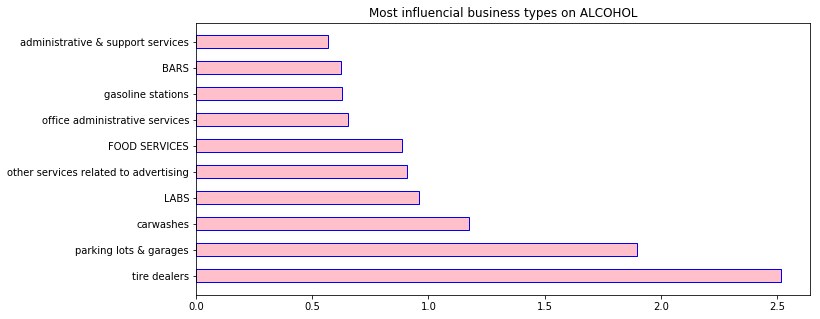

In [15]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=alcohol_near_business['offsetted_count'][:numbers_shown],
        tick_label=alcohol_near_business['ACTIVITY DESC'][:numbers_shown],
        color='pink',
        edgecolor='blue')

plt.title('Most influencial business types on ALCOHOL');

# Drugs

In [16]:
drug_df = reasonable_df[reasonable_df['crime_type'] == '*drugs*']
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in drug_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)
    if tmp % 300 == 0:
        print(tmp)
    tmp +=1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  after removing the cwd from sys.path.


0
300
600
900
1200
1500
1800


In [17]:
drug_business_total = pd.DataFrame()
drug_business_total['ACTIVITY DESC'] = pd.Series(business1 + business2 + business3).value_counts().index
drug_business_total['counts'] = pd.Series(business1 + business2 + business3).value_counts().to_list()
drug_business_total[:5]

,ACTIVITY DESC,counts
0,RETAILERS,571
1,FOOD SERVICES,368
2,PROPERTY SERVICES,295
3,AUTOMOTIVE,238
4,SCIENCE,208


In [18]:
li = []
for row in drug_business_total.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
drug_business_total['offsetted_count'] = li
drug_business_total.sort_values(by='offsetted_count', inplace=True, ascending=False)
drug_business_total = drug_business_total[drug_business_total['counts']>20]
drug_business_total[:10]

,ACTIVITY DESC,counts,offsetted_count
44,other services related to advertising,27,0.843750
39,parking lots & garages,30,0.517241
37,gasoline stations,31,0.500000
13,BARS,116,0.398625
42,personal care services,28,0.318182
6,NON-PROFIT,173,0.316850
17,limited-service eating places,82,0.297101
34,FURNITURE,34,0.293103
1,FOOD SERVICES,368,0.272795
48,TRAVEL,25,0.265957


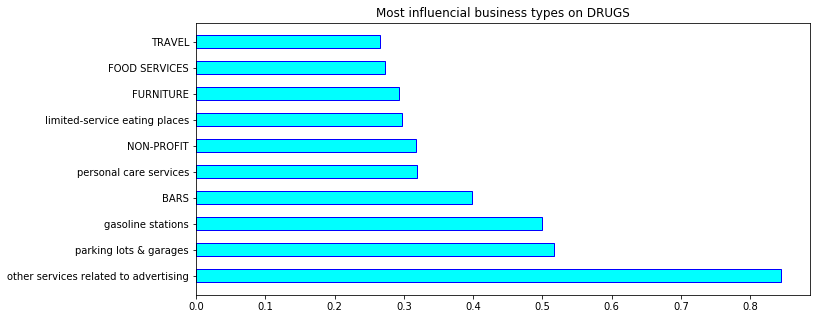

In [19]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=drug_business_total['offsetted_count'][:numbers_shown],
        tick_label=drug_business_total['ACTIVITY DESC'][:numbers_shown],
        color='cyan',
        edgecolor='blue');

plt.title('Most influencial business types on DRUGS');

# Fight / battery

In [20]:
fight_df = reasonable_df[reasonable_df['crime_type'] == '*fight / battery*']
# this block may take 3 min
business1 = []
business2 = []
business3 = []
distance1 = []
distance2 = []
distance3 = []

tmp = 0
for row in fight_df.itertuples():
    target = closest_3_business(row[2], row[3])
    insert_adapter(business1, business2, business3, distance1, distance2, distance3, target)
    if tmp % 300 == 0:
        print(tmp)
    tmp +=1

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Vincenty is deprecated and is going to be removed in geopy 2.0. Use `geopy.distance.geodesic` (or the default `geopy.distance.distance`) instead, which is more accurate and always converges.
  after removing the cwd from sys.path.


0
300
600
900
1200
1500
1800
2100


In [21]:
fight_business_total = pd.DataFrame()
fight_business_total['ACTIVITY DESC'] = pd.Series(business1 + business2 + business3).value_counts().index
fight_business_total['counts'] = pd.Series(business1 + business2 + business3).value_counts().to_list()
fight_business_total[:5]

,ACTIVITY DESC,counts
0,RETAILERS,637
1,FOOD SERVICES,616
2,PROPERTY SERVICES,356
3,janitorial services,315
4,AUTOMOTIVE,250


In [22]:
li = []
for row in fight_business_total.itertuples():
    busi_type = row[1]
    near_count = row[2]
    busi_amount = busi_value_counts[busi_value_counts['ACTIVITY DESC'] == busi_type].iloc[0,1]
    li.append(near_count/busi_amount)
fight_business_total['offsetted_count'] = li
fight_business_total.sort_values(by='offsetted_count', inplace=True, ascending=False)
fight_business_total = fight_business_total[fight_business_total['counts']>20]
fight_business_total[:10]

,ACTIVITY DESC,counts,offsetted_count
48,hotels (exc casino hotels) & motels,33,3.000000
32,gasoline stations,49,0.790323
57,pedi-cab (individual),25,0.735294
40,parking lots & garages,38,0.655172
1,FOOD SERVICES,616,0.456635
15,BARS,122,0.419244
42,personal care services,35,0.397727
25,"hair, nail & skin care services",60,0.344828
20,CLOTHING,91,0.333333
65,administrative & support services,21,0.323077


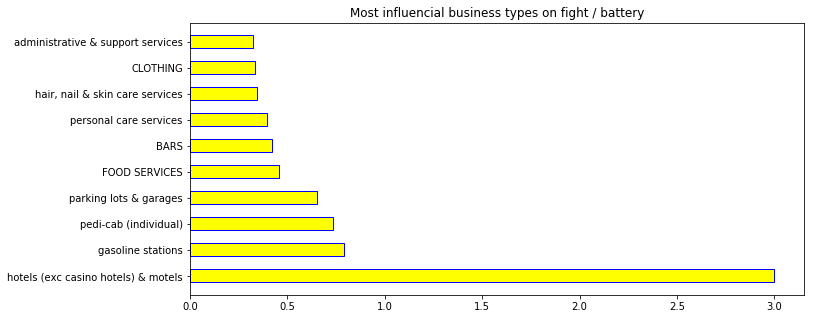

In [23]:
numbers_shown = 10

plt.figure(figsize=(11,5))

plt.barh(y=[i for i in range(1,numbers_shown+1)],
        height=0.5,
        width=fight_business_total['offsetted_count'][:numbers_shown],
        tick_label=fight_business_total['ACTIVITY DESC'][:numbers_shown],
        color='yellow',
        edgecolor='blue');

plt.title('Most influencial business types on fight / battery');